In [4]:
!pip install yfinance ta cryptocompare

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.1 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=e2bbc94b416edd7fdca85b4d6cc6ad06ae76c4d3dd1b411168c2c2e3b1219907
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6289 sha256=6d229d29c17c26115ba23fe43de6f439827d6caaf2a485e3e2a332c50179c4d2
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293631 sha256=9

In [5]:
!pip install keras

#Adding the labeler

In [6]:
import yfinance as yf
from tensorflow.keras.utils import to_categorical
import cryptocompare
import pandas as pd
from datetime import datetime
import ta
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV , train_test_split , GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score , mean_squared_error
from scipy.stats import rv_continuous
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as mpl
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

2024-08-12 13:22:00.738632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 13:22:00.738745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 13:22:00.886157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
def validate_columns(required_columns):
    def decorator(func):
        def wrapper(self, data):
            if not all(column in data.columns for column in required_columns):
                missing_columns = [column for column in required_columns if column not in data.columns]
                raise ValueError(f"The input DataFrame is missing the following required columns: {', '.join(missing_columns)}")
            return func(self, data)
        return wrapper
    return decorator

In [8]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

In [9]:
class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
      """
      Calculate the daily volatility of closing prices.

      Parameters:
      - close: A pandas Series of closing prices.
      - span0: The span for the EWM standard deviation.

      Returns:
      - A pandas Series of daily volatility estimates.
      """
      # Ensure there are no duplicate indices
      close = close[~close.index.duplicated(keep='first')]

      # Calculate daily returns
      daily_returns = close.pct_change().dropna()

      # Calculate EWM standard deviation of daily returns
      daily_vol = daily_returns.ewm(span=span0).std()

      return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

class TrueRangeLabeler(Labeler):
    def __init__(self, data):
        """
        Initialize the labeler.
        """
        super().__init__("true range labeler")
        self.data = data.copy()
        self.fit()

    def fit(self):
        """
        Fit the labeler to the data.

        Args:
        data (pd.DataFrame): The data to fit the labeler to.
        """
        # Calculate the True Range
        self.data['high_low'] = self.data['high'] - self.data['low']
        self.data['high_prev_close'] = np.abs(self.data['high'] - self.data['close'].shift())
        self.data['low_prev_close'] = np.abs(self.data['low'] - self.data['close'].shift())

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        self.data['true_range'] = self.data[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)

        # Normalize the True Range to be between 0 and 1
        self.data['label'] = (self.data['true_range'] - self.data['true_range'].min()) / (self.data['true_range'].max() - self.data['true_range'].min())

        return self.data


class ImpactScoreLabeler(Labeler):
    def __init__(self, name, direction_labeler, intensity_labeler):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        direction_labeler (Labeler): The labeler for the direction.
        intensity_labeler (Labeler): The labeler for the intensity.
        """
        super().__init__(name)
        self.direction_labeler = direction_labeler
        self.intensity_labeler = intensity_labeler

    def fit(self, data):
        """
        Fit the labeler to the data.

        Args:
        data (pd.DataFrame): The data to fit the labeler to.
        """
        self.direction_labeler.fit(data)
        self.intensity_labeler.fit(data)

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        direction_labels = self.direction_labeler.transform(up_label=1, down_label=-1, neutral_label=0)
        intensity_labels = self.intensity_labeler.transform()

        # Calculate the impact score
        impact_score = direction_labels * intensity_labels

        return impact_score

#Adding the data collection part

In [ ]:
# Set your CryptoCompare API key
API_KEY = 'b6dfe5e92faae8babd8876ec5627fd483b1f6b0b8c8583709c114c9e7282869d'
cryptocompare.cryptocompare._set_api_key_parameter(API_KEY)

# Fetch Bitcoin OHLCV data from CryptoCompare
def fetch_btc_data():
    data = []
    start_date = datetime(2015, 1, 1)
    end_date = datetime(2021, 5, 31)

    while start_date < end_date:
        limit = (end_date - start_date).days
        limit = min(limit, 2000)  # CryptoCompare limit is 2000
        to_ts = int((start_date + pd.DateOffset(days=limit)).timestamp())
        chunk_data = cryptocompare.get_historical_price_day('BTC', currency='USD', toTs=to_ts, limit=limit)
        data.extend(chunk_data)
        start_date += pd.DateOffset(days=limit)

    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

btc_data = fetch_btc_data()
btc_data['Adj Close'] = btc_data['close']

In [ ]:
# Fetch Ethereum Close data from CryptoCompare
def fetch_eth_data():
    data = []
    start_date = datetime(2015, 1, 1)
    end_date = datetime(2021, 5, 31)

    while start_date < end_date:
        limit = (end_date - start_date).days
        limit = min(limit, 2000)  # CryptoCompare limit is 2000
        to_ts = int((start_date + pd.DateOffset(days=limit)).timestamp())
        chunk_data = cryptocompare.get_historical_price_day('ETH', currency='USD', toTs=to_ts, limit=limit)
        data.extend(chunk_data)
        start_date += pd.DateOffset(days=limit)

    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

eth_data = fetch_eth_data()

In [ ]:
# Fetch Gold Close data from yfinance
def fetch_gold_data():
    gold = yf.download("GC=F", start="2015-01-01", end="2021-05-31")
    return gold['Close']

gold_data = fetch_gold_data()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Align ETH and Gold data with BTC data
eth_data = eth_data.reindex(btc_data.index, method='ffill')
gold_data = gold_data.reindex(btc_data.index, method='ffill')

In [ ]:
# Add ETH and Gold data to BTC dataframe
btc_data['ETH Close'] = eth_data['close']
btc_data['Gold Close'] = gold_data

# Calculate the volume in USD
btc_data['volume'] = btc_data['volumeto']

# Drop unnecessary columns
btc_data.drop(columns=['volumefrom', 'conversionType', 'conversionSymbol' , 'volumeto'], inplace=True)

# Check the data
print(btc_data.head())

              high     low    open   close  Adj Close  ETH Close   Gold Close  \

time                                                                            

2015-01-01  321.36  313.54  318.24  314.89     314.89        0.0          NaN   

2015-01-02  316.40  313.08  314.89  315.21     315.21        0.0  1186.000000   

2015-01-03  315.83  284.89  315.21  287.13     287.13        0.0  1186.000000   

2015-01-04  289.94  255.87  287.13  264.72     264.72        0.0  1186.000000   

2015-01-05  278.32  262.89  264.72  274.84     274.84        0.0  1203.900024   



                 volume  

time                     

2015-01-01   4073067.10  

2015-01-02   4673971.80  

2015-01-03  14209564.70  

2015-01-04  24255392.10  

2015-01-05  14995382.75  


In [ ]:
# Define function to add technical indicators
def add_technical_indicators(df):
    df['MA7'] = df['close'].rolling(window=7).mean()
    df['MA21'] = df['close'].rolling(window=21).mean()
    df['EMA0.67'] = df['close'].ewm(span=1, adjust=False, min_periods=1).mean()
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['20dSTD'] = df['close'].rolling(window=20).std()
    df['Upper Band'] = df['MA21'] + (df['20dSTD'] * 2)
    df['Lower Band'] = df['MA21'] - (df['20dSTD'] * 2)
    df['High-Low Spread'] = df['high'] - df['low']
    df['MA Indicator'] = np.where(df['MA7'] > df['MA21'], 1, 0)

    return df

btc_data_df = add_technical_indicators(btc_data)

In [ ]:
# Normalize the features as described
def normalize_features(df):
    df_norm = df.copy()
    df_norm['MACD'] = df['MACD'] / df['close'].shift(1)
    df_norm['20dSTD'] = df['20dSTD'] / df['close'].shift(1)
    df_norm['High-Low Spread'] = df['High-Low Spread'] / df['close'].shift(1)
    df_norm['volume'] = (df['volume'] - df['volume'].shift(1)) / df['volume'].shift(1)
    df_norm['MA7'] = (df['MA7'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['MA21'] = (df['MA21'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['EMA0.67'] = (df['EMA0.67'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['EMA12'] = (df['EMA12'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['EMA26'] = (df['EMA26'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['Upper Band'] = (df['Upper Band'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['Lower Band'] = (df['Lower Band'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['Adj Close'] = (df['Adj Close'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['high'] = (df['high'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['low'] = (df['low'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['open'] = (df['open'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['close'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    df_norm['ETH Close'] = (df['ETH Close'] - df['ETH Close'].shift(1)) / df['ETH Close'].shift(1)
    df_norm['Gold Close'] = (df['Gold Close'] - df['Gold Close'].shift(1)) / df['Gold Close'].shift(1)

    # Drop original columns to only keep normalized ones
    # df_norm = df_norm.drop(columns=['open', 'high', 'low', 'close', 'MA7', 'MA21', 'EMA0.67', 'EMA12', 'EMA26', 'Upper Band', 'Lower Band', 'Adj Close'])

    return df_norm

btc_data_norm = normalize_features(btc_data)

# Drop NaN values that appear because of normalization calculations
# btc_data_norm.dropna(inplace=True)

# Check the normalized data
print(btc_data_norm.head())

                high       low  open     close  Adj Close  ETH Close  \

time                                                                   

2015-01-01       NaN       NaN   NaN       NaN        NaN        NaN   

2015-01-02  0.004795 -0.005748   0.0  0.001016   0.001016        NaN   

2015-01-03  0.001967 -0.096190   0.0 -0.089083  -0.089083        NaN   

2015-01-04  0.009787 -0.108871   0.0 -0.078048  -0.078048        NaN   

2015-01-05  0.051375 -0.006913   0.0  0.038229   0.038229        NaN   



            Gold Close    volume  MA7  MA21   EMA0.67     EMA12     EMA26  \

time                                                                        

2015-01-01         NaN       NaN  NaN   NaN       NaN       NaN       NaN   

2015-01-02         NaN  0.147531  NaN   NaN  0.001016  0.000156  0.000075   

2015-01-03    0.000000  2.040148  NaN   NaN -0.089083 -0.014432 -0.007469   

2015-01-04    0.000000  0.706976  NaN   NaN -0.078048  0.057337  0.077178   

2015-01-05    0.015

In [ ]:
btc_data_norm = btc_data_norm[1:]

In [ ]:
# Function to clean data by replacing infinite values with NaN and then filling NaNs
def clean_data(df):
    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaNs with the previous day's value or zero if no previous value exists
    df.fillna(method='ffill', inplace=True)
    df.fillna(0, inplace=True)

    return df
# Clean the data
btc_data_norm = clean_data(btc_data_norm)

<ipython-input-53-97adf1fd4cc3>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  df.fillna(method='ffill', inplace=True)


In [ ]:
btc_data_norm

,high,low,open,close,Adj Close,ETH Close,Gold Close,volume,MA7,MA21,EMA0.67,EMA12,EMA26,MACD,20dSTD,Upper Band,Lower Band,High-Low Spread,MA Indicator
time,,,,,,,,,,,,,,,,,,,
2015-01-02,0.004795,-0.005748,0.0,0.001016,0.001016,0.000000,0.000000,0.147531,0.000000,0.000000,0.001016,0.000156,0.000075,0.000081,0.000000,0.000000,0.000000,0.010543,0
2015-01-03,0.001967,-0.096190,0.0,-0.089083,-0.089083,0.000000,0.000000,2.040148,0.000000,0.000000,-0.089083,-0.014432,-0.007469,-0.006963,0.000000,0.000000,0.000000,0.098157,0
2015-01-04,0.009787,-0.108871,0.0,-0.078048,-0.078048,0.000000,0.000000,0.706976,0.000000,0.000000,-0.078048,0.057337,0.077178,-0.019841,0.000000,0.000000,0.000000,0.118657,0
2015-01-05,0.051375,-0.006913,0.0,0.038229,0.038229,0.000000,0.015093,-0.381771,0.000000,0.000000,0.038229,0.130136,0.158727,-0.028591,0.000000,0.000000,0.000000,0.058288,0
2015-01-06,0.037367,-0.012080,0.0,0.027034,0.027034,0.000000,0.012792,-0.593365,0.000000,0.000000,0.027034,0.079063,0.109466,-0.030404,0.000000,0.000000,0.000000,0.049447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,0.028346,-0.053015,0.0,-0.019245,-0.019245,-0.050697,-0.002945,-0.308204,-0.037983,0.160951,-0.019245,0.034469,0.150078,-0.115609,0.199633,0.560217,-0.238315,0.081362,0
2021-05-28,0.008842,-0.098734,0.0,-0.074157,-0.074157,-0.120373,0.003587,0.720788,-0.025294,0.156928,-0.074157,0.034933,0.154364,-0.119430,0.191611,0.540150,-0.226295,0.107576,0
2021-05-29,0.045576,-0.056469,0.0,-0.029970,-0.029970,-0.055456,0.000000,-0.314581,0.041246,0.217121,-0.029970,0.095090,0.226321,-0.131231,0.191345,0.599810,-0.165568,0.102044,0


#fit the labeler (SVM , LSTM)

In [ ]:
btc_data_norm

,high,low,open,close,Adj Close,ETH Close,Gold Close,volume,MA7,MA21,EMA0.67,EMA12,EMA26,MACD,20dSTD,Upper Band,Lower Band,High-Low Spread,MA Indicator
time,,,,,,,,,,,,,,,,,,,
2015-01-02,0.004795,-0.005748,0.0,0.001016,0.001016,0.000000,0.000000,0.147531,0.000000,0.000000,0.001016,0.000156,0.000075,0.000081,0.000000,0.000000,0.000000,0.010543,0
2015-01-03,0.001967,-0.096190,0.0,-0.089083,-0.089083,0.000000,0.000000,2.040148,0.000000,0.000000,-0.089083,-0.014432,-0.007469,-0.006963,0.000000,0.000000,0.000000,0.098157,0
2015-01-04,0.009787,-0.108871,0.0,-0.078048,-0.078048,0.000000,0.000000,0.706976,0.000000,0.000000,-0.078048,0.057337,0.077178,-0.019841,0.000000,0.000000,0.000000,0.118657,0
2015-01-05,0.051375,-0.006913,0.0,0.038229,0.038229,0.000000,0.015093,-0.381771,0.000000,0.000000,0.038229,0.130136,0.158727,-0.028591,0.000000,0.000000,0.000000,0.058288,0
2015-01-06,0.037367,-0.012080,0.0,0.027034,0.027034,0.000000,0.012792,-0.593365,0.000000,0.000000,0.027034,0.079063,0.109466,-0.030404,0.000000,0.000000,0.000000,0.049447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,0.028346,-0.053015,0.0,-0.019245,-0.019245,-0.050697,-0.002945,-0.308204,-0.037983,0.160951,-0.019245,0.034469,0.150078,-0.115609,0.199633,0.560217,-0.238315,0.081362,0
2021-05-28,0.008842,-0.098734,0.0,-0.074157,-0.074157,-0.120373,0.003587,0.720788,-0.025294,0.156928,-0.074157,0.034933,0.154364,-0.119430,0.191611,0.540150,-0.226295,0.107576,0
2021-05-29,0.045576,-0.056469,0.0,-0.029970,-0.029970,-0.055456,0.000000,-0.314581,0.041246,0.217121,-0.029970,0.095090,0.226321,-0.131231,0.191345,0.599810,-0.165568,0.102044,0


In [ ]:
# Reset the index and rename it to 'timestamp'
btc_data_norm_reset = btc_data_norm.reset_index().rename(columns={'time': 'timestamp'})

# Set the 'timestamp' column as the new index
btc_data_norm_reset.set_index('timestamp', inplace=True)

# Display the first few rows to verify the changes
print(btc_data_norm_reset.head())

                high       low  open     close  Adj Close  ETH Close  \

timestamp                                                              

2015-01-02  0.004795 -0.005748   0.0  0.001016   0.001016        0.0   

2015-01-03  0.001967 -0.096190   0.0 -0.089083  -0.089083        0.0   

2015-01-04  0.009787 -0.108871   0.0 -0.078048  -0.078048        0.0   

2015-01-05  0.051375 -0.006913   0.0  0.038229   0.038229        0.0   

2015-01-06  0.037367 -0.012080   0.0  0.027034   0.027034        0.0   



            Gold Close    volume  MA7  MA21   EMA0.67     EMA12     EMA26  \

timestamp                                                                   

2015-01-02    0.000000  0.147531  0.0   0.0  0.001016  0.000156  0.000075   

2015-01-03    0.000000  2.040148  0.0   0.0 -0.089083 -0.014432 -0.007469   

2015-01-04    0.000000  0.706976  0.0   0.0 -0.078048  0.057337  0.077178   

2015-01-05    0.015093 -0.381771  0.0   0.0  0.038229  0.130136  0.158727   

2015-01-06    0.012

In [ ]:
# Initialize the labeler
labeler = TripleBarrierLabeler(volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

# Fit the labeler
labeler.fit(btc_data_norm_reset)

# Transform the data to generate labels
labeled_data = labeler.transform()

# Save the labeled data to a new CSV file
labeled_data.to_csv('labeled_dataset.csv', index=False)

print("Labeling complete. Labeled data saved to 'labeled_dataset.csv'")

Labeling complete. Labeled data saved to 'labeled_dataset.csv'


In [ ]:
labeled_data

,high,low,open,close,Adj Close,ETH Close,Gold Close,volume,MA7,MA21,...,Upper Band,Lower Band,High-Low Spread,MA Indicator,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.004795,-0.005748,0.0,0.001016,0.001016,0.000000,0.000000,0.147531,0.000000,0.000000,...,0.000000,0.000000,0.010543,0,NaN,NaN,1,True,NaN,NaN
2015-01-03,0.001967,-0.096190,0.0,-0.089083,-0.089083,0.000000,0.000000,2.040148,0.000000,0.000000,...,0.000000,0.000000,0.098157,0,-88.660917,NaN,1,False,NaN,NaN
2015-01-04,0.009787,-0.108871,0.0,-0.078048,-0.078048,0.000000,0.000000,0.706976,0.000000,0.000000,...,0.000000,0.000000,0.118657,0,-0.123875,62.605143,1,False,NaN,NaN
2015-01-05,0.051375,-0.006913,0.0,0.038229,0.038229,0.000000,0.015093,-0.381771,0.000000,0.000000,...,0.000000,0.000000,0.058288,0,-1.489813,46.754785,1,False,NaN,NaN
2015-01-06,0.037367,-0.012080,0.0,0.027034,0.027034,0.000000,0.012792,-0.593365,0.000000,0.000000,...,0.000000,0.000000,0.049447,0,-0.292844,37.349618,1,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,0.028346,-0.053015,0.0,-0.019245,-0.019245,-0.050697,-0.002945,-0.308204,-0.037983,0.160951,...,0.560217,-0.238315,0.081362,0,-1.813875,6.223075,1,False,0.192042,-0.14475
2021-05-28,0.008842,-0.098734,0.0,-0.074157,-0.074157,-0.120373,0.003587,0.720788,-0.025294,0.156928,...,0.540150,-0.226295,0.107576,0,2.853275,6.076077,1,False,0.192042,-0.14475
2021-05-29,0.045576,-0.056469,0.0,-0.029970,-0.029970,-0.055456,0.000000,-0.314581,0.041246,0.217121,...,0.599810,-0.165568,0.102044,0,-0.595863,5.284925,1,False,0.192042,-0.14475


In [ ]:
labeled_data["lower_barrier"].info()

<class 'pandas.core.series.Series'>

DatetimeIndex: 2343 entries, 2015-01-02 to 2021-05-31

Series name: lower_barrier

Non-Null Count  Dtype  

--------------  -----  

2329 non-null   float64

dtypes: float64(1)

memory usage: 36.6 KB


In [10]:
# Drop rows with NaN values in 'lower_barrier' and 'upper_barrier'
labeled_data_cleaned = labeled_data.dropna(subset=['lower_barrier', 'upper_barrier'])

In [ ]:
labeled_data_cleaned

,high,low,open,close,Adj Close,ETH Close,Gold Close,volume,MA7,MA21,...,Upper Band,Lower Band,High-Low Spread,MA Indicator,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-10,0.004445,-0.055527,0.0,-0.050769,-0.050769,0.000000,0.000000,-0.304509,-0.029075,0.000000,...,0.000000,0.000000,0.059972,0,-3.718170,18.118284,2,True,-0.970620,0.869081
2015-01-11,0.017048,-0.035083,0.0,-0.031388,-0.031388,0.000000,0.000000,-0.005933,0.022880,0.000000,...,0.000000,0.000000,0.052131,0,-0.381744,15.565025,2,False,-0.970620,0.869081
2015-01-12,0.031386,-0.005552,0.0,0.017222,0.017222,0.000000,0.013734,0.673474,0.053054,0.000000,...,0.000000,0.000000,0.036938,0,-1.548691,13.340261,2,False,-0.970620,0.869081
2015-01-13,-0.000854,-0.193926,0.0,-0.178369,-0.178369,0.000000,0.001298,2.296843,0.002880,0.000000,...,0.000000,0.000000,0.193072,0,-11.356719,12.082793,2,False,-0.970620,0.869081
2015-01-14,0.043246,-0.289213,0.0,-0.254734,-0.254734,0.000000,0.000081,0.446920,0.138984,0.000000,...,0.000000,0.000000,0.332460,0,0.428131,10.741668,2,True,-2.990997,2.481530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,0.028346,-0.053015,0.0,-0.019245,-0.019245,-0.050697,-0.002945,-0.308204,-0.037983,0.160951,...,0.560217,-0.238315,0.081362,0,-1.813875,6.223075,1,False,0.192042,-0.144750
2021-05-28,0.008842,-0.098734,0.0,-0.074157,-0.074157,-0.120373,0.003587,0.720788,-0.025294,0.156928,...,0.540150,-0.226295,0.107576,0,2.853275,6.076077,1,False,0.192042,-0.144750
2021-05-29,0.045576,-0.056469,0.0,-0.029970,-0.029970,-0.055456,0.000000,-0.314581,0.041246,0.217121,...,0.599810,-0.165568,0.102044,0,-0.595863,5.284925,1,False,0.192042,-0.144750


In [ ]:
labeled_data_cleaned["label"].unique()

array([2, 1, 0])

In [ ]:
labeled_data_cleaned.columns

Index(['high', 'low', 'open', 'close', 'Adj Close', 'ETH Close', 'Gold Close',
       'volume', 'MA7', 'MA21', 'EMA0.67', 'EMA12', 'EMA26', 'MACD', '20dSTD',
       'Upper Band', 'Lower Band', 'High-Low Spread', 'MA Indicator',
       'daily_returns', 'volatility', 'label', 'window_start', 'upper_barrier',
       'lower_barrier'],
      dtype='object')

#Prepare fpr training the model

In [ ]:
columns_to_remove = ['window_start', 'upper_barrier', 'lower_barrier', 'daily_returns', 'volatility']
btc_data_cleaned = labeled_data_cleaned.drop(columns=columns_to_remove)

# Display the first few rows to verify the changes
print(btc_data_cleaned.head())

# Split the data into training/validation and test sets
# Define the split date for the last year
split_date = btc_data_cleaned.index[-365]  # Assuming the data is daily and in chronological order

# Split the data
train_data = btc_data_cleaned[btc_data_cleaned.index < split_date]
test_data = btc_data_cleaned[btc_data_cleaned.index >= split_date]

# Display the shape of the resulting sets to verify the split
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Extract features and labels
X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
X_test = test_data.drop(columns=['label']).values
y_test = test_data['label'].values

# Reshape the data for LSTM input [samples, time steps, features]
X_train_LSTM = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_LSTM = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

                high       low  open     close  Adj Close  ETH Close  \

timestamp                                                              

2015-01-10  0.004445 -0.055527   0.0 -0.050769  -0.050769        0.0   

2015-01-11  0.017048 -0.035083   0.0 -0.031388  -0.031388        0.0   

2015-01-12  0.031386 -0.005552   0.0  0.017222   0.017222        0.0   

2015-01-13 -0.000854 -0.193926   0.0 -0.178369  -0.178369        0.0   

2015-01-14  0.043246 -0.289213   0.0 -0.254734  -0.254734        0.0   



            Gold Close    volume       MA7  MA21   EMA0.67     EMA12  \

timestamp                                                              

2015-01-10    0.000000 -0.304509 -0.029075   0.0 -0.050769  0.006569   

2015-01-11    0.000000 -0.005933  0.022880   0.0 -0.031388  0.046283   

2015-01-12    0.013734  0.673474  0.053054   0.0  0.017222  0.070501   

2015-01-13    0.001298  2.296843  0.002880   0.0 -0.178369  0.016877   

2015-01-14    0.000081  0.446920  0.138984   0.0 

In [ ]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

#LSTM model

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the LSTM model for multi-class classification
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=3, activation='softmax'))  # 3 units for 3 classes, softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(**kwargs)


Epoch 1/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4749 - loss: 1.0840 - val_accuracy: 0.3791 - val_loss: 1.0480

Epoch 2/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5042 - loss: 1.0130 - val_accuracy: 0.3791 - val_loss: 1.0052

Epoch 3/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5013 - loss: 0.9601 - val_accuracy: 0.3766 - val_loss: 0.9945

Epoch 4/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5129 - loss: 0.9470 - val_accuracy: 0.4427 - val_loss: 0.9904

Epoch 5/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5615 - loss: 0.9403 - val_accuracy: 0.4529 - val_loss: 0.9897

Epoch 6/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5980 - loss: 0.9337 - val_accuracy: 0.4377 - val_loss: 0.9907

Epoch 7/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5862 - loss: 0.9270 - val_accuracy: 0.4326 - val_loss: 0.9929

Epoch 8/50

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5875 - loss: 0.9208 - val_accuracy: 0.

In [ ]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display the first few predictions
print(f"Predictions: {y_pred_classes[:10]}")
print(f"Actual Labels: {y_test[:10]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Predictions: [1 1 1 2 1 2 1 1 1 1]

Actual Labels: [1 1 1 1 1 2 2 2 2 2]


In [ ]:
def evaluate_model(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm

In [ ]:
metrics = evaluate_model(y_pred_classes ,y_test )
print(f"accuracy : {metrics[0]}")
print(f"precision : {metrics[1]}")
print(f"recall : {metrics[2]}")
print(f"f1 : {metrics[3]}")
print(f"confusion matrix : {metrics[4]}")

accuracy : 0.5287671232876713

precision : 0.467681879215242

recall : 0.5287671232876713

f1 : 0.49203533984793485

confusion matrix : [[  0  19  23]

 [  0 115  47]

 [  0  83  78]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


#SVM model

In [ ]:
# Define the log-uniform distribution for hyperparameters
class logUniform_gen(rv_continuous):
    def _cdf(self, x):
        return np.log(x / self.a) / np.log(self.b / self.a)

def logUniform(a=1, b=np.exp(1)):
    return logUniform_gen(a=a, b=b, name='logUniform')

In [ ]:
# Create windowed dataset for each task
def create_windowed_dataset(data, window_size):
    X = []
    # y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size].flatten())
    return np.array(X)

In [ ]:
# Function to perform random search
def random_search_svm(X, y , param):
    param_random = param
    svm = SVC(kernel='rbf', probability=True )
    random_search = RandomizedSearchCV(svm, param_random, cv=4, scoring="neg_log_loss" , random_state=30)
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [ ]:
# Hyperparameter space / change numbers
param = {
    'C': logUniform(1e-3, 1e3),
    'gamma': logUniform(1e-4, 1e1)
}

In [ ]:
X_train_SVM = create_windowed_dataset(X_train, 5)
X_test_SVM = create_windowed_dataset(X_test, 5)

In [ ]:
X_train_SVM[0]

array([ 4.44490746e-03, -5.55266174e-02,  0.00000000e+00, -5.07691773e-02,
       -5.07691773e-02,  0.00000000e+00,  0.00000000e+00, -3.04508551e-01,
       -2.90754493e-02,  0.00000000e+00, -5.07691773e-02,  6.56878079e-03,
        3.90417640e-02, -3.24729832e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.99715248e-02,  0.00000000e+00,  1.70477410e-02,
       -3.50832266e-02,  0.00000000e+00, -3.13883300e-02, -3.13883300e-02,
        0.00000000e+00,  0.00000000e+00, -5.93282172e-03,  2.28801380e-02,
        0.00000000e+00, -3.13883300e-02,  4.62826553e-02,  8.52809001e-02,
       -3.89982448e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.21309676e-02,  0.00000000e+00,  3.13857310e-02, -5.55198852e-03,
        0.00000000e+00,  1.72224950e-02,  1.72224950e-02,  0.00000000e+00,
        1.37335125e-02,  6.73473637e-01,  5.30541332e-02,  0.00000000e+00,
        1.72224950e-02,  7.05009579e-02,  1.12803475e-01, -4.23025167e-02,
        0.00000000e+00,  

In [ ]:
model , parameters , score = random_search_svm(X_train_SVM , y_train[5:] , param)

In [ ]:
parameters

{'C': 0.014949530054368491, 'gamma': 9.353376612029603}

In [ ]:
metrics = evaluate_model(model.predict(X_test_SVM) ,y_test[5:] )
print(f"accuracy : {metrics[0]}")
print(f"precision : {metrics[1]}")
print(f"recall : {metrics[2]}")
print(f"f1 : {metrics[3]}")
print(f"confusion matrix : {metrics[4]}")

accuracy : 0.4361111111111111

precision : 0.19019290123456792

recall : 0.4361111111111111

f1 : 0.2648721255104234

confusion matrix : [[  0  42   0]

 [  0 157   0]

 [  0 161   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


# Fit the labeler (Auto Encoder)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Load the data (assuming you have the data in a CSV file)
data = pd.read_csv('/kaggle/input/btc-2years/3600.csv')  # Replace with your actual file path

# Convert the timestamp to a more readable format if needed
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Select relevant features and assume you have a 'label' column for classification
features = data[['open', 'high', 'low', 'close', 'volume', 'trade']]

In [13]:
data

,timestamp,open,high,low,close,volume,trade
0,2019-09-25 08:00:00,8325.28,8546.73,8215.00,8250.36,2999.764,6158
1,2019-09-25 09:00:00,8250.36,8403.90,8250.36,8392.49,1684.698,4093
2,2019-09-25 10:00:00,8391.37,8445.03,8355.67,8413.62,1400.901,3179
3,2019-09-25 11:00:00,8413.62,8435.71,8294.99,8327.38,1395.581,3735
4,2019-09-25 12:00:00,8324.27,8365.29,8242.61,8303.67,2107.813,4967
...,...,...,...,...,...,...,...
38827,2024-02-29 03:00:00,61831.10,61831.20,61200.00,61638.60,9370.417,157253
38828,2024-02-29 04:00:00,61638.60,62800.00,61408.30,62531.90,23215.122,291159
38829,2024-02-29 05:00:00,62531.90,62755.30,61853.30,62620.90,19852.816,273878
38830,2024-02-29 06:00:00,62620.90,63762.80,62549.20,63053.40,42580.585,535734


In [14]:
# Initialize the labeler
labeler = TripleBarrierLabeler(volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

# Fit the labeler
labeler.fit(data)

# Transform the data to generate labels
labeled_data = labeler.transform()

# Save the labeled data to a new CSV file
labeled_data.to_csv('labeled_dataset.csv', index=False)

print("Labeling complete. Labeled data saved to 'labeled_dataset.csv'")

Labeling complete. Labeled data saved to 'labeled_dataset.csv'


In [15]:
# Drop rows with NaN values in 'lower_barrier' and 'upper_barrier'
labeled_data_cleaned = labeled_data.dropna(subset=['lower_barrier', 'upper_barrier'])
columns_to_remove = ['window_start', 'upper_barrier', 'lower_barrier', 'daily_returns', 'volatility']
btc_data_cleaned = labeled_data_cleaned.drop(columns=columns_to_remove)

In [16]:
btc_data_cleaned

,index,open,high,low,close,volume,trade,label
timestamp,,,,,,,,
2019-09-25 16:00:00,8,8295.79,8353.41,8223.71,8340.05,2534.214,4791,2
2019-09-25 17:00:00,9,8340.82,8408.31,8333.00,8371.16,1901.450,3351,2
2019-09-25 18:00:00,10,8367.73,8396.37,8305.77,8341.76,1037.273,2416,2
2019-09-25 19:00:00,11,8341.75,8367.11,8314.62,8346.96,924.336,1692,2
2019-09-25 20:00:00,12,8346.96,8520.07,8338.80,8495.77,2304.849,2978,2
...,...,...,...,...,...,...,...,...
2024-02-29 03:00:00,38827,61831.10,61831.20,61200.00,61638.60,9370.417,157253,2
2024-02-29 04:00:00,38828,61638.60,62800.00,61408.30,62531.90,23215.122,291159,2
2024-02-29 05:00:00,38829,62531.90,62755.30,61853.30,62620.90,19852.816,273878,2


In [17]:
# Shift the 'label' column by -1 to move the labels to the previous day
btc_data_cleaned['shifted_label'] = btc_data_cleaned['label'].shift(-1)

# Drop the last row since it will have a NaN in the 'shifted_label' column after the shift
btc_data_cleaned = btc_data_cleaned.dropna(subset=['shifted_label'])

# Alternatively, you can drop the 'label' column and rename the 'shifted_label' column to 'label'
btc_data_cleaned = btc_data_cleaned.drop(columns=['label']).rename(columns={'shifted_label': 'label'})

In [18]:
btc_data_cleaned['label'] = btc_data_cleaned['label'].astype(int)

In [19]:
btc_data_cleaned

,index,open,high,low,close,volume,trade,label
timestamp,,,,,,,,
2019-09-25 16:00:00,8,8295.79,8353.41,8223.71,8340.05,2534.214,4791,2
2019-09-25 17:00:00,9,8340.82,8408.31,8333.00,8371.16,1901.450,3351,2
2019-09-25 18:00:00,10,8367.73,8396.37,8305.77,8341.76,1037.273,2416,2
2019-09-25 19:00:00,11,8341.75,8367.11,8314.62,8346.96,924.336,1692,2
2019-09-25 20:00:00,12,8346.96,8520.07,8338.80,8495.77,2304.849,2978,0
...,...,...,...,...,...,...,...,...
2024-02-29 02:00:00,38826,61480.60,61842.00,61171.90,61831.20,10496.887,183638,2
2024-02-29 03:00:00,38827,61831.10,61831.20,61200.00,61638.60,9370.417,157253,2
2024-02-29 04:00:00,38828,61638.60,62800.00,61408.30,62531.90,23215.122,291159,2


#Auto encoder model

In [20]:
# Convert the timestamp to a more readable format if needed
# btc_data_cleaned['timestamp'] = pd.to_datetime(btc_data_cleaned['timestamp'], unit='s')

# Select relevant features and assume you have a 'label' column for classification
features = btc_data_cleaned[['open', 'high', 'low', 'close', 'volume', 'trade']]
labels = btc_data_cleaned['label']  # Replace with the actual label column

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Convert to PyTorch tensor
series_data = torch.tensor(scaled_data, dtype=torch.float32)
labels = torch.tensor(labels.values, dtype=torch.long)  # Ensure labels are in long format

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(series_data, labels, test_size=0.2, shuffle=False)

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

class Extrapolator(nn.Module):
    def __init__(self, hidden_dim):
        super(Extrapolator, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super(Decoder, self).__init__()
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

# Initialize model parameters
input_dim = series_data.size(1)  # The number of features per timestep
hidden_dim = 16  # Latent space dimension
output_dim = input_dim  # Output dimension matches input dimension
num_layers = 2  # Number of layers in RNN

encoder = Encoder(input_dim, hidden_dim, num_layers)
extrapolator = Extrapolator(hidden_dim)
decoder = Decoder(hidden_dim, output_dim, num_layers)

# Define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(extrapolator.parameters()) + list(decoder.parameters()), lr=0.001)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Function to mask one patch
def mask_patch(series, patch_idx, patch_size):
    masked_series = series.clone()
    masked_series[patch_idx:patch_idx + patch_size, :] = 0  # Mask the selected patch
    return masked_series

# move to GPU
X_train = X_train.to(device)
encoder = encoder.to(device)
extrapolator = extrapolator.to(device)
decoder = decoder.to(device)
criterion = criterion.to(device)


# Training Loop for Reconstruction
num_epochs = 100
patch_percent = 0.3  # For example, 30% of the data will be included in each patch
total_timesteps = X_train.size(0)
patch_size = int(patch_percent * total_timesteps)
patch_size = max(1, patch_size)  # Ensure at least one timestep per patch

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Start with an empty tensor to hold the reconstructed series
    reconstructed_series = torch.zeros_like(X_train).to(device)

    for patch_idx in range(0, total_timesteps, patch_size):
        # Mask one patch at a time
        masked_series = mask_patch(X_train, patch_idx, patch_size)

        # Encode unmasked patches
        HN = encoder(masked_series.unsqueeze(0))

        # Extrapolate to get latent representations for masked patches
        H_tilde = extrapolator(HN)

        # Decode the complete latent representation back to the original feature space
        X_hat = decoder(H_tilde)

        # Place the reconstructed patch in the appropriate position
        reconstructed_series[patch_idx:patch_idx + patch_size, :] = X_hat.squeeze(0)[patch_idx:patch_idx + patch_size, :]

    # Compute the loss between the entire reconstructed series and the original series
    loss = criterion(reconstructed_series, X_train)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed!")

Epoch [10/100], Loss: 0.1603
Epoch [20/100], Loss: 0.1063
Epoch [30/100], Loss: 0.0669
Epoch [40/100], Loss: 0.0473
Epoch [50/100], Loss: 0.0465
Epoch [60/100], Loss: 0.0463
Epoch [70/100], Loss: 0.0456
Epoch [80/100], Loss: 0.0456
Epoch [90/100], Loss: 0.0455
Epoch [100/100], Loss: 0.0455
Training completed!


In [26]:
# Extract latent features from the encoder
def extract_latent_features(encoder, series_data, patch_size):
    latent_features = []

    total_timesteps = series_data.size(0)

    for patch_idx in range(0, total_timesteps, patch_size):
        masked_series = mask_patch(series_data, patch_idx, patch_size)
        HN = encoder(masked_series.unsqueeze(0))
        latent_features.append(HN.squeeze(0))

    latent_features = torch.cat(latent_features, dim=0)
    return latent_features

latent_features_train = extract_latent_features(encoder, X_train, patch_size)

# Prepare the training data for the classifier
window_size = 5  # Number of days to consider for classification
X_cls_train = []
y_cls_train = []

# Ensure that the loop does not exceed the length of y_train
for i in range(window_size, min(len(latent_features_train) - 1, len(y_train))):
    X_cls_train.append(latent_features_train[i-window_size:i, :])
    y_cls_train.append(y_train[i])  # Label for the next day

X_cls_train = torch.stack(X_cls_train)
y_cls_train = torch.tensor(y_cls_train)

# Define and Train the Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the classifier
input_dim = latent_features_train.size(1) * window_size
hidden_dim = 64
num_classes = len(torch.unique(y_cls_train))

classifier = MLPClassifier(input_dim, hidden_dim, num_classes).to(device)
criterion_cls = nn.CrossEntropyLoss().to(device)
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)

# Reshape training data to fit the classifier input
X_cls_train = X_cls_train.view(X_cls_train.size(0), -1).to(device)  # Flatten the input for MLP
y_cls_train = y_cls_train.to(device)
# Training loop for the classifier
num_epochs_cls = 50
for epoch in range(num_epochs_cls):
    classifier.train()  # Ensure the model is in training mode
    optimizer_cls.zero_grad()  # Zero the gradients

    # Forward pass
    outputs = classifier(X_cls_train)
    loss_cls = criterion_cls(outputs, y_cls_train)

    # Backpropagation and optimization
    loss_cls.backward(retain_graph=True)  # Backpropagate the error
    optimizer_cls.step()  # Update the parameters

    # Compute accuracy with torch.no_grad to avoid tracking history
    with torch.no_grad():
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_cls_train).sum().item() / y_cls_train.size(0)
        print(f'Epoch [{epoch+1}/{num_epochs_cls}], Loss: {loss_cls.item():.4f}, Accuracy: {accuracy:.4f}')

print("Classifier training completed!")


Epoch [1/50], Loss: 1.0752, Accuracy: 0.4415
Epoch [2/50], Loss: 1.0648, Accuracy: 0.4415
Epoch [3/50], Loss: 1.0560, Accuracy: 0.4415
Epoch [4/50], Loss: 1.0476, Accuracy: 0.4415
Epoch [5/50], Loss: 1.0394, Accuracy: 0.4415
Epoch [6/50], Loss: 1.0312, Accuracy: 0.4415
Epoch [7/50], Loss: 1.0228, Accuracy: 0.4415
Epoch [8/50], Loss: 1.0146, Accuracy: 0.4415
Epoch [9/50], Loss: 1.0062, Accuracy: 0.4415
Epoch [10/50], Loss: 0.9974, Accuracy: 0.4415
Epoch [11/50], Loss: 0.9884, Accuracy: 0.4415
Epoch [12/50], Loss: 0.9795, Accuracy: 0.4415
Epoch [13/50], Loss: 0.9705, Accuracy: 0.4415
Epoch [14/50], Loss: 0.9616, Accuracy: 0.4415
Epoch [15/50], Loss: 0.9528, Accuracy: 0.4415
Epoch [16/50], Loss: 0.9441, Accuracy: 0.4415
Epoch [17/50], Loss: 0.9355, Accuracy: 0.4415
Epoch [18/50], Loss: 0.9272, Accuracy: 0.4415
Epoch [19/50], Loss: 0.9193, Accuracy: 0.4415
Epoch [20/50], Loss: 0.9118, Accuracy: 0.4415
Epoch [21/50], Loss: 0.9049, Accuracy: 0.4415
Epoch [22/50], Loss: 0.8988, Accuracy: 0.44

In [27]:
latent_features_train.shape

torch.Size([123436, 16])

In [33]:
# Extract latent features for the test set
latent_features_test = extract_latent_features(encoder, X_test.to(device) , patch_size)

# Prepare the test data for the classifier
X_cls_test = []
y_cls_test = []

for i in range(window_size, len(latent_features_test) - 1):
    X_cls_test.append(latent_features_test[i-window_size:i, :])
    y_cls_test.append(y_test[i])

X_cls_test = torch.stack(X_cls_test).to(device) 
y_cls_test = torch.tensor(y_cls_test).to(device) 

# Reshape test data to fit the classifier input
X_cls_test = X_cls_test.view(X_cls_test.size(0), -1).to(device) 

# Evaluate the classifier
with torch.no_grad():
    outputs_test = classifier(X_cls_test)
    _, predicted_test = torch.max(outputs_test.data, 1)
    test_accuracy = (predicted_test == y_cls_test).sum().item() / y_cls_test.size(0)
    print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.4877


#use the OPENFFD normalization

In [ ]:
def getWeights_FFD(d, thres):
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        # print(w_)
        if abs(w_) < thres :
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def fracDiff_FFD(series, d, thres=0.01):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    # 1) Compute weights for the longest series
    w = getWeights_FFD(d, thres)
    width = len(w) - 1

    # 2) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(index=seriesF.index)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue  # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def plotMinFFD(df, col_name):
    # Ensure the index is a DatetimeIndex
    df.index = pd.to_datetime(df.index)

    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    for d in np.linspace(0, 1, 41):
        df1 = np.log(df[[col_name]]).resample('1D').last()  # downcast to daily observations
        df2 = fracDiff_FFD(df1, d, thres=.01)

        # Align and drop NaN values for correlation calculation
        combined = pd.concat([df1, df2], axis=1).dropna()
        if combined.shape[0] < 2:
            corr = np.nan
        else:
            corr = np.corrcoef(combined.iloc[:, 0], combined.iloc[:, 1])[0, 1]

        try:
            df2_adf = adfuller(df2[col_name].dropna(), maxlag=1, regression='c', autolag=None)
            out.loc[d] = list(df2_adf[:4]) + [df2_adf[4]['5%']] + [corr]  # with critical value

        except:
            print(f"ADF test failed for d={d} on column {col_name}")
            continue

    mean_conf = out['95% conf'].mean()
    # ax2.axhline(mean_conf, linewidth=1, color='r', linestyle='dotted')


    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    plt.title('ADF Statistic and Correlation vs Differentiation Order')
    plt.savefig('testMinFFD.png')
    plt.show()

    min_d_value = round (out[out['adfStat'] < mean_conf].index.min() ,3 )

    return out, min_d_value

In [ ]:
btc_data.columns

Index(['high', 'low', 'open', 'close', 'Adj Close', 'ETH Close', 'Gold Close',
       'volume', 'MA7', 'MA21', 'EMA0.67', 'EMA12', 'EMA26', 'MACD', '20dSTD',
       'Upper Band', 'Lower Band', 'High-Low Spread', 'MA Indicator'],
      dtype='object')

In [ ]:
btc_data_new = clean_data(btc_data)
btc_data_new = btc_data_new[1:]
btc_data_new

<ipython-input-18-97adf1fd4cc3>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  df.fillna(method='ffill', inplace=True)


,high,low,open,close,Adj Close,ETH Close,Gold Close,volume,MA7,MA21,EMA0.67,EMA12,EMA26,MACD,20dSTD,Upper Band,Lower Band,High-Low Spread,MA Indicator
time,,,,,,,,,,,,,,,,,,,
2015-01-02,316.40,313.08,314.89,315.21,315.21,0.00,1186.000000,4.673972e+06,0.000000,0.000000,315.21,314.939231,314.913704,0.025527,0.000000,0.000000,0.000000,3.32,0
2015-01-03,315.83,284.89,315.21,287.13,287.13,0.00,1186.000000,1.420956e+07,0.000000,0.000000,287.13,310.660888,312.855652,-2.194764,0.000000,0.000000,0.000000,30.94,0
2015-01-04,289.94,255.87,287.13,264.72,264.72,0.00,1186.000000,2.425539e+07,0.000000,0.000000,264.72,303.593059,309.290048,-5.696989,0.000000,0.000000,0.000000,34.07,0
2015-01-05,278.32,262.89,264.72,274.84,274.84,0.00,1203.900024,1.499538e+07,0.000000,0.000000,274.84,299.169511,306.738192,-7.568681,0.000000,0.000000,0.000000,15.43,0
2015-01-06,285.11,271.52,274.84,282.27,282.27,0.00,1219.300049,6.097640e+06,0.000000,0.000000,282.27,296.569586,304.925734,-8.356147,0.000000,0.000000,0.000000,13.59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,40408.95,37211.84,39295.08,38538.84,38538.84,2742.48,1895.699951,1.804037e+09,37802.538571,45619.667143,38538.84,40649.539032,45192.389814,-4542.850782,7844.596062,61308.859268,29930.475018,3197.11,0
2021-05-28,38879.60,34733.76,38538.84,35680.92,35680.92,2412.36,1902.500000,3.104364e+09,37564.042857,44586.647619,35680.92,39885.136104,44487.836494,-4602.700390,7384.477419,59355.602457,29817.692781,4145.84,0
2021-05-29,37307.10,33666.06,35680.92,34611.58,34611.58,2278.58,1902.500000,2.127790e+09,37152.625714,43428.002381,34611.58,39073.819780,43756.261939,-4682.442159,6827.352104,57082.706588,29773.298174,3641.04,0


<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna 

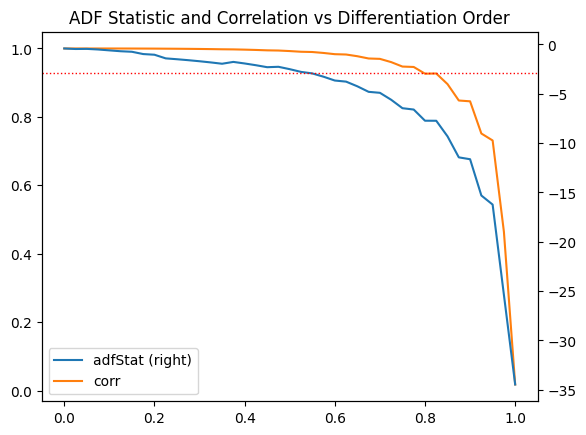

Optimal d value for close: 0.55


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib

ADF test failed for d=0.025 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.05 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.07500000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.1 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.125 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.15000000000000002 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.17500000000000002 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.2 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.225 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.25 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.275 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.30000000000000004 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.325 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.35000000000000003 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.375 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.4 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.42500000000000004 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.45 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.47500000000000003 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.5 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.525 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.55 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.5750000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.6000000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.625 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.65 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.675 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.7000000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.7250000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.75 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.775 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.8 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.8250000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.8500000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.875 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.9 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.925 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.9500000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract

  a = op(a[slice1], a[slice2])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log

  result = func(self.values, **kwargs)

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()


ADF test failed for d=0.9750000000000001 on column ETH Close


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract

  X -= avg[:, None]


ADF test failed for d=1.0 on column ETH Close


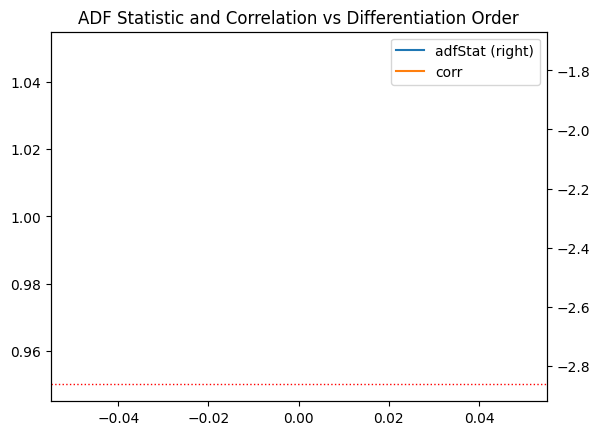

Optimal d value for ETH Close: nan


<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna 

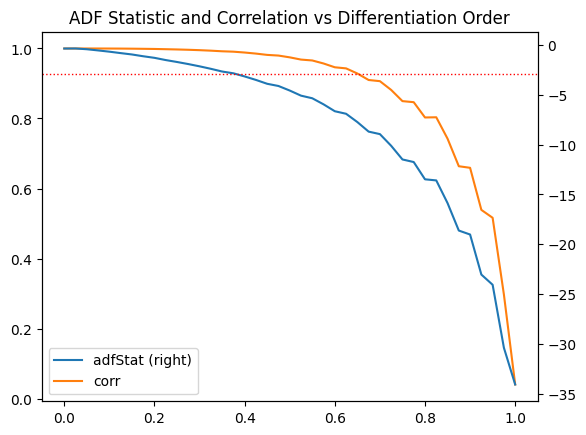

Optimal d value for Gold Close: 0.4


<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

  seriesF = series[[name]].fillna(method='ffill').dropna()

<ipython-input-35-7ce5a163ab74>:27: FutureWarning: DataFrame.fillna 

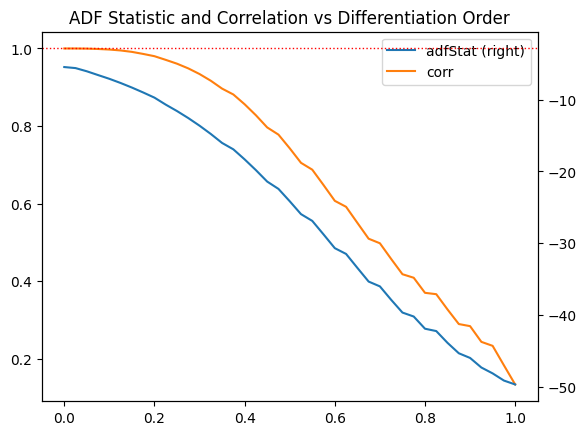

Optimal d value for volume: 0.0


In [ ]:
# Clean data to remove NaNs and Infs
btc_data_new = btc_data_new.replace([np.inf, -np.inf], np.nan).dropna()

# Columns to be normalized
columns_to_normalize = ['high', 'low', 'open', 'close', 'Adj Close', 'ETH Close', 'Gold Close',
                        'volume', 'MA7', 'MA21', 'EMA0.67', 'EMA12', 'EMA26', 'MACD', '20dSTD',
                        'Upper Band', 'Lower Band', 'High-Low Spread']

# Get d values for 'close', 'ETH Close', 'Gold Close', and 'volume'
d_values = {}
for col in ['close', 'ETH Close', 'Gold Close', 'volume']:
    _, d_value = plotMinFFD(btc_data_new, col)
    d_values[col] = d_value
    print(f"Optimal d value for {col}: {d_value}")